In [ ]:
# Mount into drive

from google.colab import drive

drive.mount("/content/drive")

%cd '/content/drive/MyDrive/final_project/'

!pip install -r requirements.txt

Mounted at /content/drive
/content/drive/MyDrive/final_project
INFO: pip is looking at multiple versions of jupyterlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jupyterlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 56.6 MB/s eta 0:00:00
   ━━━━

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, AdamW
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Transformer
from sklearn.metrics import accuracy_score
from bert_model import BERT
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt
import os

# **Add classifier for sentiment analysis project**

In [ ]:
class SentimentClassifier(nn.Module):
    """
    A classifier on top of the BERT model for sentiment analysis.
    """

    def __init__(self, bert, num_classes=3):
        """
        Initializes the sentiment classifier.

        :param bert: Pretrained BERT model
        :param num_classes: Number of sentiment classes (default is 3: negative, neutral, positive)
        """
        super().__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(bert.d_model, num_classes)

    def forward(self, input_ids, segment_ids, attention_mask):
        """
        Forward pass for sentiment classification.

        :param input_ids: Tokenized input sequence
        :param segment_ids: Segment information (usually all zeros for single sentences)
        :param attention_mask: Mask to avoid attention on padding tokens
        """
        bert_output = self.bert(input_ids, segment_ids)
        cls_output = bert_output[:, 0]  # [CLS] token output
        logits = self.classifier(self.dropout(cls_output))
        return logits


    def load_pretrained_bert(checkpoint_path, vocab_size, d_model=1024, n_layers=24, heads=16, dropout=0.1):
    # def load_pretrained_bert(checkpoint_path, vocab_size, d_model=768, n_layers=12, heads=12, dropout=0.1):
        bert = BERT(vocab_size=vocab_size, d_model=d_model, n_layers=n_layers, heads=heads, dropout=dropout)

        checkpoint = torch.load(checkpoint_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

        # Load only the model's weights
        # bert.optim.load_state_dict(checkpoint['optimizer_state_dict'])
        bert.load_state_dict(checkpoint['model_state_dict'], strict=False)


        print(f"Loaded model weights from checkpoint: {checkpoint_path}")
        return bert

# Dataset and Dataloader
class SentimentDataset(Dataset):
    def __init__(self, file_path, tokenizer, max_len):
        self.file_path = file_path
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.sentences, self.labels = self.load_data()

    def load_data(self):
        sentences = []
        labels = []

        with open(self.file_path, 'r', encoding='latin1') as file:
            for line_num, line in enumerate(file, start=1):
                line = line.strip()
                if '@' not in line or len(line.split('@')) != 2:
                    print(f"Skipping malformed line {line_num}: {line}")
                    continue

                text, label = line.split('@')
                sentences.append(text.strip())
                labels.append(label.strip())

        return sentences, labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]

        inputs = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].squeeze(0)
        attention_mask = inputs['attention_mask'].squeeze(0)
        segment_ids = torch.zeros_like(input_ids)  # Single sentence -> segment_ids all zero

        label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
        label = label_map[label]

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'segment_ids': segment_ids,
            'labels': torch.tensor(label, dtype=torch.long)
        }


# **Preprocess data**

In [ ]:
def train_sentiment_classifier(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct_predictions = 0, 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        segment_ids = batch['segment_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, segment_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels).item()

    return total_loss / len(dataloader), correct_predictions / len(dataloader.dataset)

def evaluate_sentiment_classifier(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct_predictions = 0, 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            segment_ids = batch['segment_ids'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, segment_ids, attention_mask)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels).item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = correct_predictions / len(dataloader.dataset)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    mcc = matthews_corrcoef(all_labels, all_preds)

    # Compute specificity per class and macro-average specificity
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
    specificity_per_class = []
    for i in range(len(cm)):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity_per_class.append(specificity)

    specificity = sum(specificity_per_class) / len(specificity_per_class)

    return {
        'loss': total_loss / len(dataloader),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mcc': mcc,
        'specificity': specificity,
    }


In [ ]:
def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1):
    """
    Splits the dataset into training, validation, and test sets.

    :param dataset: Full dataset to split
    :param train_ratio: Proportion of data for training
    :param val_ratio: Proportion of data for validation
    :return: Train, validation, and test datasets
    """
    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size

    return random_split(dataset, [train_size, val_size, test_size])

# **Train BERT-Large with Cross Entropy loss**

Using device: cuda
Loaded model weights from checkpoint: data/bert_checkpoints/bert_checkpoint_epoch_24.pt


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50 - Train Loss: 1.0099, Train Accuracy: 0.5842
Epoch 1/50 - Val Loss: 0.9809, Val Accuracy: 0.5442
Epoch 1/50 - Test Loss: 0.8588, Test Accuracy: 0.6388
Precision: 0.4080, Recall: 0.6388, F1-Score: 0.4980
Specificity: 0.6667, MCC: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/50 - Train Loss: 0.9250, Train Accuracy: 0.6223
Epoch 2/50 - Val Loss: 0.9126, Val Accuracy: 0.6239
Epoch 2/50 - Test Loss: 0.8029, Test Accuracy: 0.7093
Precision: 0.5896, Recall: 0.7093, F1-Score: 0.6385
Specificity: 0.7773, MCC: 0.3672


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/50 - Train Loss: 0.8913, Train Accuracy: 0.6444
Epoch 3/50 - Val Loss: 0.9131, Val Accuracy: 0.6283
Epoch 3/50 - Test Loss: 0.7651, Test Accuracy: 0.7225
Precision: 0.6062, Recall: 0.7225, F1-Score: 0.6557
Specificity: 0.7917, MCC: 0.4046


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/50 - Train Loss: 0.8595, Train Accuracy: 0.6659
Epoch 4/50 - Val Loss: 0.9028, Val Accuracy: 0.6372
Epoch 4/50 - Test Loss: 0.7411, Test Accuracy: 0.7489
Precision: 0.6400, Recall: 0.7489, F1-Score: 0.6897
Specificity: 0.8226, MCC: 0.4781


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/50 - Train Loss: 0.8101, Train Accuracy: 0.7035
Epoch 5/50 - Val Loss: 0.9262, Val Accuracy: 0.6327
Epoch 5/50 - Test Loss: 0.7316, Test Accuracy: 0.7401
Precision: 0.6288, Recall: 0.7401, F1-Score: 0.6785
Specificity: 0.8101, MCC: 0.4533


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/50 - Train Loss: 0.8149, Train Accuracy: 0.7145
Epoch 6/50 - Val Loss: 0.8582, Val Accuracy: 0.6460
Epoch 6/50 - Test Loss: 0.6995, Test Accuracy: 0.7401
Precision: 0.6485, Recall: 0.7401, F1-Score: 0.6907
Specificity: 0.8340, MCC: 0.4775


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/50 - Train Loss: 0.7741, Train Accuracy: 0.7112
Epoch 7/50 - Val Loss: 0.8409, Val Accuracy: 0.6549
Epoch 7/50 - Test Loss: 0.7094, Test Accuracy: 0.7313
Precision: 0.6635, Recall: 0.7313, F1-Score: 0.6913
Specificity: 0.8454, MCC: 0.4858


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/50 - Train Loss: 0.7643, Train Accuracy: 0.7305
Epoch 8/50 - Val Loss: 0.8646, Val Accuracy: 0.6593
Epoch 8/50 - Test Loss: 0.6844, Test Accuracy: 0.7621
Precision: 0.6557, Recall: 0.7621, F1-Score: 0.7049
Specificity: 0.8369, MCC: 0.5126


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9/50 - Train Loss: 0.7553, Train Accuracy: 0.7338
Epoch 9/50 - Val Loss: 0.8215, Val Accuracy: 0.6549
Epoch 9/50 - Test Loss: 0.6722, Test Accuracy: 0.7445
Precision: 0.6525, Recall: 0.7445, F1-Score: 0.6949
Specificity: 0.8380, MCC: 0.4870


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10/50 - Train Loss: 0.7430, Train Accuracy: 0.7421
Epoch 10/50 - Val Loss: 0.8214, Val Accuracy: 0.6681
Epoch 10/50 - Test Loss: 0.6619, Test Accuracy: 0.7577
Precision: 0.7954, Recall: 0.7577, F1-Score: 0.7112
Specificity: 0.8437, MCC: 0.5116
Epoch 11/50 - Train Loss: 0.7233, Train Accuracy: 0.7465
Epoch 11/50 - Val Loss: 0.8212, Val Accuracy: 0.6858
Epoch 11/50 - Test Loss: 0.6562, Test Accuracy: 0.7709
Precision: 0.7672, Recall: 0.7709, F1-Score: 0.7316
Specificity: 0.8474, MCC: 0.5345


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12/50 - Train Loss: 0.7265, Train Accuracy: 0.7587
Epoch 12/50 - Val Loss: 0.7984, Val Accuracy: 0.6726
Epoch 12/50 - Test Loss: 0.6534, Test Accuracy: 0.7665
Precision: 0.8182, Recall: 0.7665, F1-Score: 0.7256
Specificity: 0.8627, MCC: 0.5472


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13/50 - Train Loss: 0.7382, Train Accuracy: 0.7432
Epoch 13/50 - Val Loss: 0.8036, Val Accuracy: 0.6770
Epoch 13/50 - Test Loss: 0.6474, Test Accuracy: 0.7709
Precision: 0.8112, Recall: 0.7709, F1-Score: 0.7255
Specificity: 0.8581, MCC: 0.5446
Epoch 14/50 - Train Loss: 0.7168, Train Accuracy: 0.7504
Epoch 14/50 - Val Loss: 0.8255, Val Accuracy: 0.6947
Epoch 14/50 - Test Loss: 0.6561, Test Accuracy: 0.7753
Precision: 0.7591, Recall: 0.7753, F1-Score: 0.7299
Specificity: 0.8493, MCC: 0.5425
Epoch 15/50 - Train Loss: 0.7144, Train Accuracy: 0.7626
Epoch 15/50 - Val Loss: 0.7753, Val Accuracy: 0.6903
Epoch 15/50 - Test Loss: 0.6362, Test Accuracy: 0.7665
Precision: 0.7760, Recall: 0.7665, F1-Score: 0.7328
Specificity: 0.8651, MCC: 0.5492
Epoch 16/50 - Train Loss: 0.6847, Train Accuracy: 0.7808
Epoch 16/50 - Val Loss: 0.8009, Val Accuracy: 0.7035
Epoch 16/50 - Test Loss: 0.6396, Test Accuracy: 0.7841
Precision: 0.7825, Recall: 0.7841, F1-Score: 0.7460
Specificity: 0.8618, MCC: 0.5666


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18/50 - Train Loss: 0.6676, Train Accuracy: 0.7797
Epoch 18/50 - Val Loss: 0.7826, Val Accuracy: 0.6858
Epoch 18/50 - Test Loss: 0.6371, Test Accuracy: 0.7841
Precision: 0.8233, Recall: 0.7841, F1-Score: 0.7439
Specificity: 0.8681, MCC: 0.5748
Epoch 19/50 - Train Loss: 0.6712, Train Accuracy: 0.7935
Epoch 19/50 - Val Loss: 0.7936, Val Accuracy: 0.7212
Epoch 19/50 - Test Loss: 0.6397, Test Accuracy: 0.8062
Precision: 0.8115, Recall: 0.8062, F1-Score: 0.7777
Specificity: 0.8734, MCC: 0.6119
Epoch 20/50 - Train Loss: 0.6857, Train Accuracy: 0.7902
Epoch 20/50 - Val Loss: 0.7731, Val Accuracy: 0.6991
Epoch 20/50 - Test Loss: 0.6426, Test Accuracy: 0.7665
Precision: 0.7899, Recall: 0.7665, F1-Score: 0.7367
Specificity: 0.8738, MCC: 0.5658
Epoch 21/50 - Train Loss: 0.6653, Train Accuracy: 0.7891
Epoch 21/50 - Val Loss: 0.8027, Val Accuracy: 0.7035
Epoch 21/50 - Test Loss: 0.6490, Test Accuracy: 0.7974
Precision: 0.7952, Recall: 0.7974, F1-Score: 0.7589
Specificity: 0.8718, MCC: 0.5961


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 23/50 - Train Loss: 0.6354, Train Accuracy: 0.8156
Epoch 23/50 - Val Loss: 0.7925, Val Accuracy: 0.7080
Epoch 23/50 - Test Loss: 0.6543, Test Accuracy: 0.7709
Precision: 0.8405, Recall: 0.7709, F1-Score: 0.7404
Specificity: 0.8776, MCC: 0.5802
Epoch 24/50 - Train Loss: 0.6529, Train Accuracy: 0.7891
Epoch 24/50 - Val Loss: 0.7380, Val Accuracy: 0.7611
Epoch 24/50 - Test Loss: 0.5972, Test Accuracy: 0.8326
Precision: 0.8374, Recall: 0.8326, F1-Score: 0.8162
Specificity: 0.8870, MCC: 0.6661
Epoch 25/50 - Train Loss: 0.6339, Train Accuracy: 0.8100
Epoch 25/50 - Val Loss: 0.7285, Val Accuracy: 0.7611
Epoch 25/50 - Test Loss: 0.5905, Test Accuracy: 0.8370
Precision: 0.8250, Recall: 0.8370, F1-Score: 0.8264
Specificity: 0.8920, MCC: 0.6747
Epoch 26/50 - Train Loss: 0.6179, Train Accuracy: 0.8172
Epoch 26/50 - Val Loss: 0.7074, Val Accuracy: 0.7611
Epoch 26/50 - Test Loss: 0.5775, Test Accuracy: 0.8502
Precision: 0.8550, Recall: 0.8502, F1-Score: 0.8450
Specificity: 0.9056, MCC: 0.7075


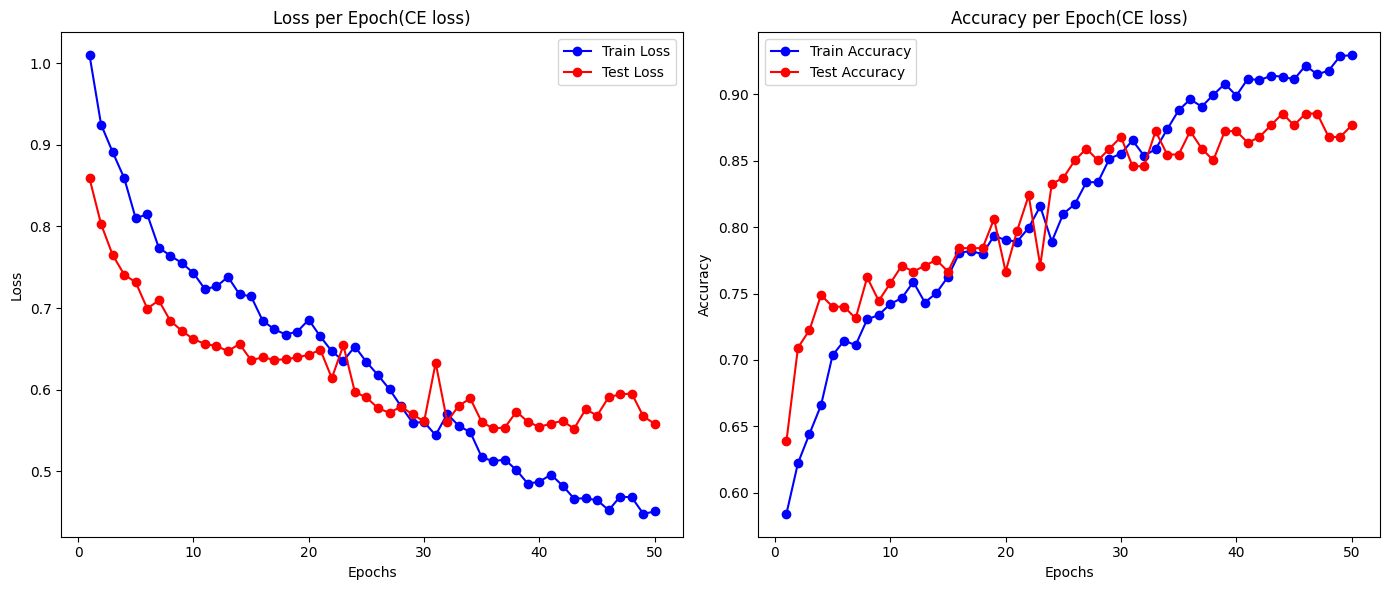

In [ ]:
def main():
    # Hyperparameters
    vocab_size = 30522
    d_model = 768
    n_layers = 6
    heads = 8
    dropout = 0.5
    max_len = 64
    batch_size = 128
    learning_rate = 1e-5
    weight_decay = 1e-4
    num_epochs = 50
    checkpoint_path = "data/bert_checkpoints/bert_checkpoint_epoch_24.pt"
    output_dir = "data/output"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    dataset = SentimentDataset("data/Sentences_AllAgree.txt", tokenizer, max_len)

    train_dataset, val_dataset, test_dataset = split_dataset(dataset, train_ratio=0.8, val_ratio=0.1)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    bert = SentimentClassifier.load_pretrained_bert(checkpoint_path, vocab_size, d_model, n_layers, heads, dropout)
    sentiment_model = SentimentClassifier(bert).to(device)

    optimizer = optim.AdamW(sentiment_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Metrics storage for visualization
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_sentiment_classifier(sentiment_model, train_dataloader, optimizer, criterion, device)
        val_metrics = evaluate_sentiment_classifier(sentiment_model, val_dataloader, criterion, device)
        test_metrics = evaluate_sentiment_classifier(sentiment_model, test_dataloader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_metrics['loss'])
        test_accuracies.append(test_metrics['accuracy'])

        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Epoch {epoch + 1}/{num_epochs} - Val Loss: {val_metrics['loss']:.4f}, Val Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"Epoch {epoch + 1}/{num_epochs} - Test Loss: {test_metrics['loss']:.4f}, Test Accuracy: {test_metrics['accuracy']:.4f}")
        print(f"Precision: {test_metrics['precision']:.4f}, Recall: {test_metrics['recall']:.4f}, F1-Score: {test_metrics['f1']:.4f}")
        print(f"Specificity: {test_metrics['specificity']:.4f}, MCC: {test_metrics['mcc']:.4f}")

    # Final evaluation on test set
    final_test_metrics = evaluate_sentiment_classifier(sentiment_model, test_dataloader, criterion, device)
    print(f"Final Test Loss: {final_test_metrics['loss']:.4f}, Final Test Accuracy: {final_test_metrics['accuracy']:.4f}")
    print(f"Precision: {final_test_metrics['precision']:.4f}, Recall: {final_test_metrics['recall']:.4f}, F1-Score: {final_test_metrics['f1']:.4f}")
    print(f"Specificity: {final_test_metrics['specificity']:.4f}, MCC: {final_test_metrics['mcc']:.4f}")

    # Visualization
    plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, output_dir)

def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    epochs = range(1, len(train_losses) + 1)

    # Loss plot
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="blue", marker="o")
    plt.plot(epochs, test_losses, label="Test Loss", color="red", marker="o")
    plt.title("Loss per Epoch(CE loss)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color="blue", marker="o")
    plt.plot(epochs, test_accuracies, label="Test Accuracy", color="red", marker="o")
    plt.title("Accuracy per Epoch(CE loss)")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plot_path = os.path.join(output_dir, "train_test_comparison_CE_loss.png")
    plt.savefig(plot_path)
    # print(f"Plot saved to {'data'}")
    plt.show()
if __name__ == "__main__":
    main()

# **Train BERT-Large with Focal loss**

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, num_classes=3, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Convert targets to one-hot encoding
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).float()

        # Compute Cross-Entropy Loss
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')

        # Probability of the true class
        pt = torch.sum(F.softmax(inputs, dim=1) * targets_one_hot, dim=1)

        # Ensure alpha is on the same device as targets
        alpha_t = self.alpha.to(targets.device)[targets]  # Shape: (batch_size,)

        # Compute Focal Loss
        focal_loss = alpha_t * ((1 - pt) ** self.gamma) * ce_loss

        # Reduce loss based on specified reduction method
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


Using device: cuda
Loaded model weights from checkpoint: data/bert_checkpoints/bert_checkpoint_epoch_24.pt


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50 - Train Loss: 0.1708, Train Accuracy: 0.4092
Epoch 1/50 - Val Loss: 0.1466, Val Accuracy: 0.1416
Epoch 1/50 - Test Loss: 0.1453, Test Accuracy: 0.1454
Precision: 0.6171, Recall: 0.1454, F1-Score: 0.0829
Specificity: 0.6783, MCC: 0.0875
Epoch 2/50 - Train Loss: 0.1586, Train Accuracy: 0.4208
Epoch 2/50 - Val Loss: 0.1194, Val Accuracy: 0.6239
Epoch 2/50 - Test Loss: 0.1137, Test Accuracy: 0.6432
Precision: 0.7012, Recall: 0.6432, F1-Score: 0.5918
Specificity: 0.8138, MCC: 0.4058
Epoch 3/50 - Train Loss: 0.1468, Train Accuracy: 0.4627
Epoch 3/50 - Val Loss: 0.1138, Val Accuracy: 0.7212
Epoch 3/50 - Test Loss: 0.1072, Test Accuracy: 0.7093
Precision: 0.6859, Recall: 0.7093, F1-Score: 0.6783
Specificity: 0.8082, MCC: 0.4330


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/50 - Train Loss: 0.1308, Train Accuracy: 0.5284
Epoch 4/50 - Val Loss: 0.1066, Val Accuracy: 0.6372
Epoch 4/50 - Test Loss: 0.1013, Test Accuracy: 0.6608
Precision: 0.8193, Recall: 0.6608, F1-Score: 0.5905
Specificity: 0.8212, MCC: 0.4377


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/50 - Train Loss: 0.1303, Train Accuracy: 0.5489
Epoch 5/50 - Val Loss: 0.1100, Val Accuracy: 0.6327
Epoch 5/50 - Test Loss: 0.1060, Test Accuracy: 0.6388
Precision: 0.5596, Recall: 0.6388, F1-Score: 0.5798
Specificity: 0.8292, MCC: 0.4427


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/50 - Train Loss: 0.1253, Train Accuracy: 0.5870
Epoch 6/50 - Val Loss: 0.1026, Val Accuracy: 0.6504
Epoch 6/50 - Test Loss: 0.0958, Test Accuracy: 0.6476
Precision: 0.5510, Recall: 0.6476, F1-Score: 0.5817
Specificity: 0.8264, MCC: 0.4408


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/50 - Train Loss: 0.1218, Train Accuracy: 0.5809
Epoch 7/50 - Val Loss: 0.1061, Val Accuracy: 0.6460
Epoch 7/50 - Test Loss: 0.0988, Test Accuracy: 0.6520
Precision: 0.5488, Recall: 0.6520, F1-Score: 0.5831
Specificity: 0.8260, MCC: 0.4434
Epoch 8/50 - Train Loss: 0.1173, Train Accuracy: 0.6074
Epoch 8/50 - Val Loss: 0.0955, Val Accuracy: 0.6637
Epoch 8/50 - Test Loss: 0.0845, Test Accuracy: 0.6696
Precision: 0.7228, Recall: 0.6696, F1-Score: 0.6298
Specificity: 0.8332, MCC: 0.4565
Epoch 9/50 - Train Loss: 0.1095, Train Accuracy: 0.6162
Epoch 9/50 - Val Loss: 0.0950, Val Accuracy: 0.7301
Epoch 9/50 - Test Loss: 0.0819, Test Accuracy: 0.7357
Precision: 0.7403, Recall: 0.7357, F1-Score: 0.7254
Specificity: 0.8505, MCC: 0.5132
Epoch 10/50 - Train Loss: 0.1075, Train Accuracy: 0.6361
Epoch 10/50 - Val Loss: 0.0938, Val Accuracy: 0.6460
Epoch 10/50 - Test Loss: 0.0809, Test Accuracy: 0.6740
Precision: 0.8471, Recall: 0.6740, F1-Score: 0.6253
Specificity: 0.8425, MCC: 0.4903
Epoch 11/

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12/50 - Train Loss: 0.1033, Train Accuracy: 0.6499
Epoch 12/50 - Val Loss: 0.1016, Val Accuracy: 0.6770
Epoch 12/50 - Test Loss: 0.0876, Test Accuracy: 0.6740
Precision: 0.8316, Recall: 0.6740, F1-Score: 0.6025
Specificity: 0.8323, MCC: 0.4675
Epoch 13/50 - Train Loss: 0.1043, Train Accuracy: 0.6737
Epoch 13/50 - Val Loss: 0.0948, Val Accuracy: 0.6593
Epoch 13/50 - Test Loss: 0.0793, Test Accuracy: 0.6652
Precision: 0.8351, Recall: 0.6652, F1-Score: 0.6111
Specificity: 0.8331, MCC: 0.4640
Epoch 14/50 - Train Loss: 0.0955, Train Accuracy: 0.6726
Epoch 14/50 - Val Loss: 0.0957, Val Accuracy: 0.7035
Epoch 14/50 - Test Loss: 0.0779, Test Accuracy: 0.7225
Precision: 0.8118, Recall: 0.7225, F1-Score: 0.6834
Specificity: 0.8481, MCC: 0.5277
Epoch 15/50 - Train Loss: 0.0946, Train Accuracy: 0.6924
Epoch 15/50 - Val Loss: 0.0918, Val Accuracy: 0.7257
Epoch 15/50 - Test Loss: 0.0730, Test Accuracy: 0.7401
Precision: 0.7868, Recall: 0.7401, F1-Score: 0.7280
Specificity: 0.8630, MCC: 0.5500


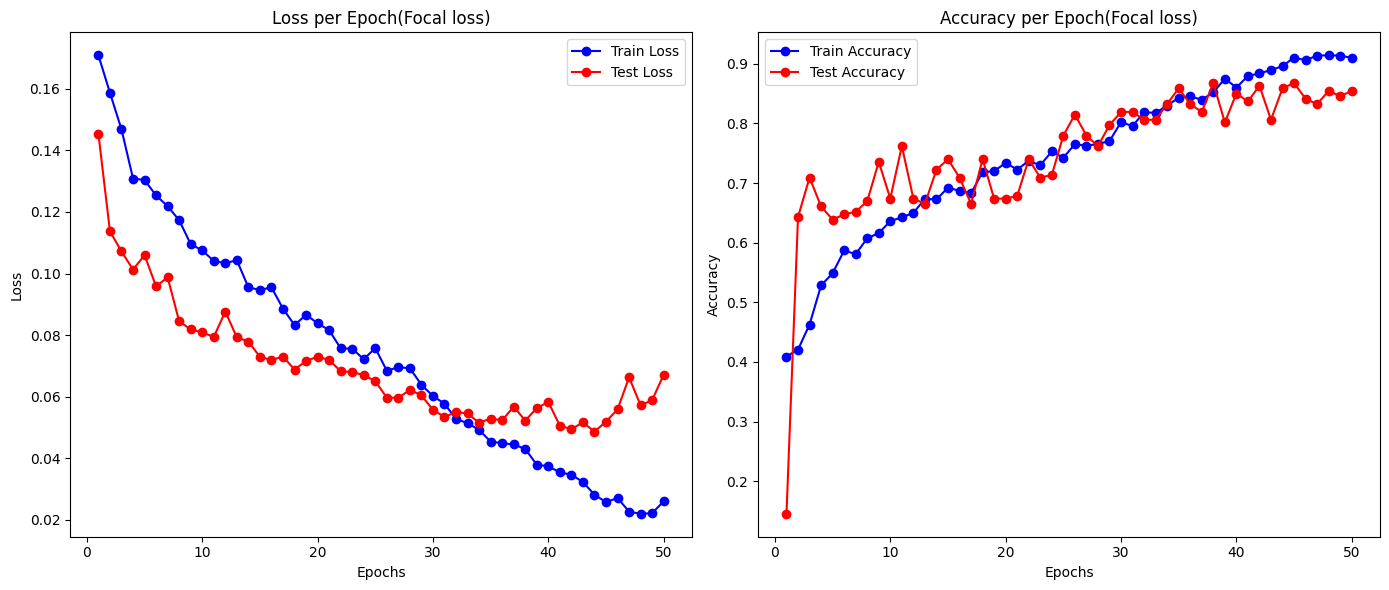

In [ ]:
def main():
    # Hyperparameters
    vocab_size = 30522
    d_model = 768
    n_layers = 6
    heads = 8
    dropout = 0.5
    max_len = 64
    batch_size = 128
    learning_rate = 1e-5
    weight_decay = 1e-4
    num_epochs = 50
    checkpoint_path = "data/bert_checkpoints/bert_checkpoint_epoch_24.pt"
    output_dir = "data/output"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    dataset = SentimentDataset("data/Sentences_AllAgree.txt", tokenizer, max_len)

    train_dataset, val_dataset, test_dataset = split_dataset(dataset, train_ratio=0.8, val_ratio=0.1)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    bert = SentimentClassifier.load_pretrained_bert(checkpoint_path, vocab_size, d_model, n_layers, heads, dropout)
    sentiment_model = SentimentClassifier(bert).to(device)

    optimizer = optim.AdamW(sentiment_model.parameters(), lr=learning_rate, weight_decay= weight_decay)
    # Use FocalLoss instead of CrossEntropyLoss
    alpha = torch.tensor([0.6, 0.15, 0.25]) # Base on the distribution on dataset: 604 negative, 2879 neutral, and 1363 positive
    criterion = FocalLoss(alpha=alpha, gamma=1.5, num_classes=3)
    # criterion = FocalLoss(alpha=alpha, gamma=4.0, num_classes=3)

    # Metrics storage for visualization
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_sentiment_classifier(sentiment_model, train_dataloader, optimizer, criterion, device)
        val_metrics = evaluate_sentiment_classifier(sentiment_model, val_dataloader, criterion, device)
        test_metrics = evaluate_sentiment_classifier(sentiment_model, test_dataloader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_metrics['loss'])
        test_accuracies.append(test_metrics['accuracy'])

        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Epoch {epoch + 1}/{num_epochs} - Val Loss: {val_metrics['loss']:.4f}, Val Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"Epoch {epoch + 1}/{num_epochs} - Test Loss: {test_metrics['loss']:.4f}, Test Accuracy: {test_metrics['accuracy']:.4f}")
        print(f"Precision: {test_metrics['precision']:.4f}, Recall: {test_metrics['recall']:.4f}, F1-Score: {test_metrics['f1']:.4f}")
        print(f"Specificity: {test_metrics['specificity']:.4f}, MCC: {test_metrics['mcc']:.4f}")

    # Final evaluation on test set
    final_test_metrics = evaluate_sentiment_classifier(sentiment_model, test_dataloader, criterion, device)
    print(f"Final Test Loss: {final_test_metrics['loss']:.4f}, Final Test Accuracy: {final_test_metrics['accuracy']:.4f}")
    print(f"Precision: {final_test_metrics['precision']:.4f}, Recall: {final_test_metrics['recall']:.4f}, F1-Score: {final_test_metrics['f1']:.4f}")
    print(f"Specificity: {final_test_metrics['specificity']:.4f}, MCC: {final_test_metrics['mcc']:.4f}")

    # Visualization
    plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, output_dir)

def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    epochs = range(1, len(train_losses) + 1)

    # Loss plot
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="blue", marker="o")
    plt.plot(epochs, test_losses, label="Test Loss", color="red", marker="o")
    plt.title("Loss per Epoch(Focal loss)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color="blue", marker="o")
    plt.plot(epochs, test_accuracies, label="Test Accuracy", color="red", marker="o")
    plt.title("Accuracy per Epoch(Focal loss)")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plot_path = os.path.join(output_dir, "train_test_comparison_CE_loss.png")
    plt.savefig(plot_path)
    # print(f"Plot saved to {'data'}")
    plt.show()
if __name__ == "__main__":
    main()

# **Train BERT-Base with Cross Entropy loss**

Using device: cuda
Loaded model weights from checkpoint: data/bert_checkpoints/bert_checkpoint_epoch_2.pt


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50 - Train Loss: 1.0045, Train Accuracy: 0.5599
Epoch 1/50 - Val Loss: 0.9950, Val Accuracy: 0.6150
Epoch 1/50 - Test Loss: 0.8262, Test Accuracy: 0.6784
Precision: 0.5983, Recall: 0.6784, F1-Score: 0.5580
Specificity: 0.6781, MCC: 0.1307


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/50 - Train Loss: 0.8881, Train Accuracy: 0.6201
Epoch 2/50 - Val Loss: 0.8633, Val Accuracy: 0.6770
Epoch 2/50 - Test Loss: 0.6949, Test Accuracy: 0.7621
Precision: 0.6612, Recall: 0.7621, F1-Score: 0.7041
Specificity: 0.8037, MCC: 0.4564


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/50 - Train Loss: 0.8352, Train Accuracy: 0.6444
Epoch 3/50 - Val Loss: 0.8228, Val Accuracy: 0.6814
Epoch 3/50 - Test Loss: 0.6480, Test Accuracy: 0.7533
Precision: 0.6652, Recall: 0.7533, F1-Score: 0.7065
Specificity: 0.8231, MCC: 0.4538


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/50 - Train Loss: 0.7629, Train Accuracy: 0.6753
Epoch 4/50 - Val Loss: 0.8099, Val Accuracy: 0.6681
Epoch 4/50 - Test Loss: 0.6364, Test Accuracy: 0.7709
Precision: 0.6965, Recall: 0.7709, F1-Score: 0.7306
Specificity: 0.8512, MCC: 0.5157


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/50 - Train Loss: 0.7230, Train Accuracy: 0.6952
Epoch 5/50 - Val Loss: 0.9637, Val Accuracy: 0.7080
Epoch 5/50 - Test Loss: 0.7644, Test Accuracy: 0.7621
Precision: 0.6678, Recall: 0.7621, F1-Score: 0.7115
Specificity: 0.8243, MCC: 0.4682


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/50 - Train Loss: 0.6914, Train Accuracy: 0.7057
Epoch 6/50 - Val Loss: 0.7849, Val Accuracy: 0.6991
Epoch 6/50 - Test Loss: 0.6244, Test Accuracy: 0.7577
Precision: 0.6869, Recall: 0.7577, F1-Score: 0.7191
Specificity: 0.8430, MCC: 0.4885


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/50 - Train Loss: 0.6952, Train Accuracy: 0.7112
Epoch 7/50 - Val Loss: 0.8306, Val Accuracy: 0.7124
Epoch 7/50 - Test Loss: 0.6749, Test Accuracy: 0.7841
Precision: 0.6939, Recall: 0.7841, F1-Score: 0.7363
Specificity: 0.8465, MCC: 0.5282


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/50 - Train Loss: 0.6444, Train Accuracy: 0.7366
Epoch 8/50 - Val Loss: 0.7243, Val Accuracy: 0.6991
Epoch 8/50 - Test Loss: 0.6121, Test Accuracy: 0.7709
Precision: 0.7129, Recall: 0.7709, F1-Score: 0.7358
Specificity: 0.8640, MCC: 0.5385


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9/50 - Train Loss: 0.6224, Train Accuracy: 0.7333
Epoch 9/50 - Val Loss: 0.7299, Val Accuracy: 0.7035
Epoch 9/50 - Test Loss: 0.6078, Test Accuracy: 0.7709
Precision: 0.7129, Recall: 0.7709, F1-Score: 0.7358
Specificity: 0.8640, MCC: 0.5385
Epoch 10/50 - Train Loss: 0.5872, Train Accuracy: 0.7526
Epoch 10/50 - Val Loss: 0.7196, Val Accuracy: 0.7434
Epoch 10/50 - Test Loss: 0.5949, Test Accuracy: 0.8018
Precision: 0.7949, Recall: 0.8018, F1-Score: 0.7910
Specificity: 0.8677, MCC: 0.5792
Epoch 11/50 - Train Loss: 0.5905, Train Accuracy: 0.7471
Epoch 11/50 - Val Loss: 0.6900, Val Accuracy: 0.7212
Epoch 11/50 - Test Loss: 0.6111, Test Accuracy: 0.7401
Precision: 0.8246, Recall: 0.7401, F1-Score: 0.7203
Specificity: 0.8587, MCC: 0.5059
Epoch 12/50 - Train Loss: 0.5628, Train Accuracy: 0.7548
Epoch 12/50 - Val Loss: 0.6735, Val Accuracy: 0.7434
Epoch 12/50 - Test Loss: 0.5807, Test Accuracy: 0.8106
Precision: 0.8198, Recall: 0.8106, F1-Score: 0.8088
Specificity: 0.8869, MCC: 0.6159
Epo

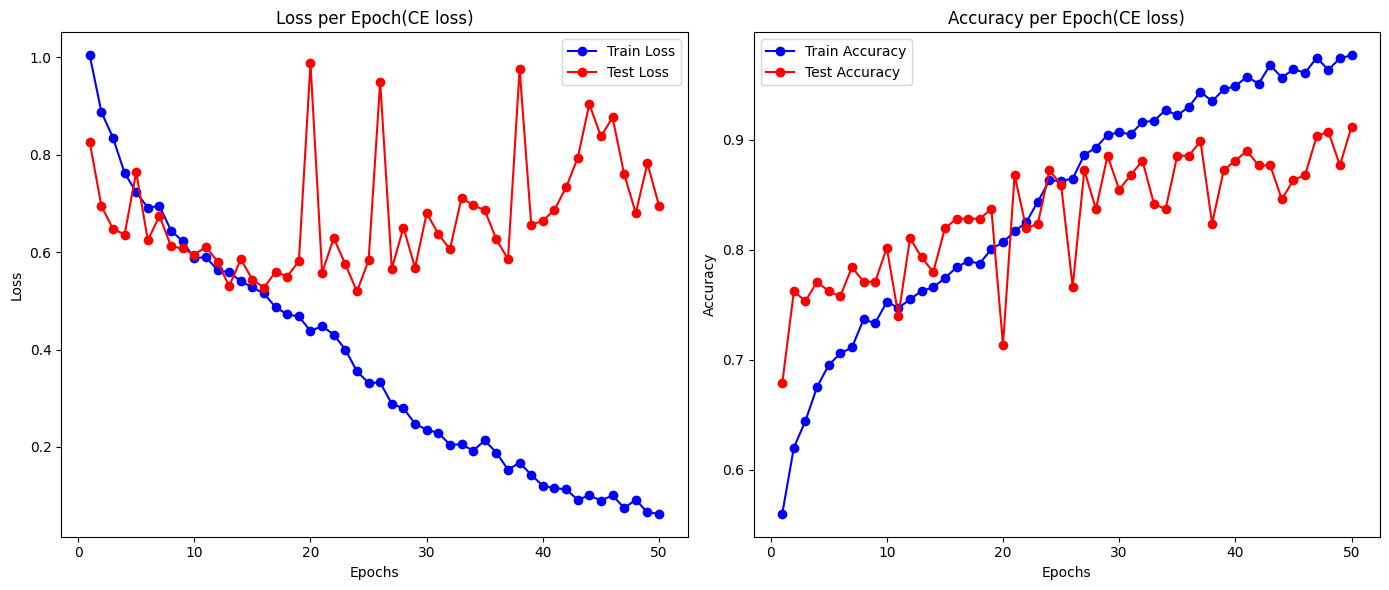

In [ ]:
def main():
    # Hyperparameters
    vocab_size = 30522
    d_model = 768
    n_layers = 12
    heads = 12
    dropout = 0.7
    max_len = 64
    batch_size = 64
    learning_rate = 1e-5
    weight_decay = 1e-3
    num_epochs = 50
    checkpoint_path = "data/bert_checkpoints/bert_checkpoint_epoch_2.pt"
    output_dir = "data/output"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    dataset = SentimentDataset("data/Sentences_AllAgree.txt", tokenizer, max_len)

    train_dataset, val_dataset, test_dataset = split_dataset(dataset, train_ratio=0.8, val_ratio=0.1)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    bert = SentimentClassifier.load_pretrained_bert(checkpoint_path, vocab_size, d_model, n_layers, heads, dropout)
    sentiment_model = SentimentClassifier(bert).to(device)

    optimizer = optim.AdamW(sentiment_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Metrics storage for visualization
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_sentiment_classifier(sentiment_model, train_dataloader, optimizer, criterion, device)
        val_metrics = evaluate_sentiment_classifier(sentiment_model, val_dataloader, criterion, device)
        test_metrics = evaluate_sentiment_classifier(sentiment_model, test_dataloader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_metrics['loss'])
        test_accuracies.append(test_metrics['accuracy'])

        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Epoch {epoch + 1}/{num_epochs} - Val Loss: {val_metrics['loss']:.4f}, Val Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"Epoch {epoch + 1}/{num_epochs} - Test Loss: {test_metrics['loss']:.4f}, Test Accuracy: {test_metrics['accuracy']:.4f}")
        print(f"Precision: {test_metrics['precision']:.4f}, Recall: {test_metrics['recall']:.4f}, F1-Score: {test_metrics['f1']:.4f}")
        print(f"Specificity: {test_metrics['specificity']:.4f}, MCC: {test_metrics['mcc']:.4f}")

    # Final evaluation on test set
    final_test_metrics = evaluate_sentiment_classifier(sentiment_model, test_dataloader, criterion, device)
    print(f"Final Test Loss: {final_test_metrics['loss']:.4f}, Final Test Accuracy: {final_test_metrics['accuracy']:.4f}")
    print(f"Precision: {final_test_metrics['precision']:.4f}, Recall: {final_test_metrics['recall']:.4f}, F1-Score: {final_test_metrics['f1']:.4f}")
    print(f"Specificity: {final_test_metrics['specificity']:.4f}, MCC: {final_test_metrics['mcc']:.4f}")

    # Visualization
    plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, output_dir)

def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    epochs = range(1, len(train_losses) + 1)

    # Loss plot
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="blue", marker="o")
    plt.plot(epochs, test_losses, label="Test Loss", color="red", marker="o")
    plt.title("Loss per Epoch(CE loss)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color="blue", marker="o")
    plt.plot(epochs, test_accuracies, label="Test Accuracy", color="red", marker="o")
    plt.title("Accuracy per Epoch(CE loss)")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plot_path = os.path.join(output_dir, "train_test_comparison_CE_loss.png")
    plt.savefig(plot_path)
    # print(f"Plot saved to {'data'}")
    plt.show()
if __name__ == "__main__":
    main()

# **Train BERT-Base with Focal loss**

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, num_classes=3, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes
        self.reduction = reduction


    def forward(self, inputs, targets):
        # Convert targets to one-hot encoding
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).float()

        # Compute Cross-Entropy Loss
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')

        # Probability of the true class
        pt = torch.sum(F.softmax(inputs, dim=1) * targets_one_hot, dim=1)

        # Ensure alpha is on the same device as targets
        alpha_t = self.alpha.to(targets.device)[targets]  # Shape: (batch_size,)

        # Compute Focal Loss
        focal_loss = alpha_t * ((1 - pt) ** self.gamma) * ce_loss

        # Reduce loss based on specified reduction method
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


Using device: cuda
Loaded model weights from checkpoint: data/bert_checkpoints/bert_checkpoint_epoch_2.pt
Epoch 1/50 - Train Loss: 0.1836, Train Accuracy: 0.3606
Epoch 1/50 - Val Loss: 0.1283, Val Accuracy: 0.5354
Epoch 1/50 - Test Loss: 0.1022, Test Accuracy: 0.5771
Precision: 0.6954, Recall: 0.5771, F1-Score: 0.5955
Specificity: 0.7893, MCC: 0.3073


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/50 - Train Loss: 0.1621, Train Accuracy: 0.4362
Epoch 2/50 - Val Loss: 0.1114, Val Accuracy: 0.5619
Epoch 2/50 - Test Loss: 0.0931, Test Accuracy: 0.6167
Precision: 0.5935, Recall: 0.6167, F1-Score: 0.5828
Specificity: 0.8187, MCC: 0.3893


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/50 - Train Loss: 0.1504, Train Accuracy: 0.4865
Epoch 3/50 - Val Loss: 0.1146, Val Accuracy: 0.5310
Epoch 3/50 - Test Loss: 0.0934, Test Accuracy: 0.5286
Precision: 0.6018, Recall: 0.5286, F1-Score: 0.5303
Specificity: 0.7997, MCC: 0.3298


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/50 - Train Loss: 0.1361, Train Accuracy: 0.5373
Epoch 4/50 - Val Loss: 0.1330, Val Accuracy: 0.6239
Epoch 4/50 - Test Loss: 0.1143, Test Accuracy: 0.6740
Precision: 0.5995, Recall: 0.6740, F1-Score: 0.6179
Specificity: 0.8369, MCC: 0.4507


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/50 - Train Loss: 0.1293, Train Accuracy: 0.5919
Epoch 5/50 - Val Loss: 0.1231, Val Accuracy: 0.5885
Epoch 5/50 - Test Loss: 0.0971, Test Accuracy: 0.6256
Precision: 0.6243, Recall: 0.6256, F1-Score: 0.6007
Specificity: 0.8402, MCC: 0.4294


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/50 - Train Loss: 0.1291, Train Accuracy: 0.6035
Epoch 6/50 - Val Loss: 0.1116, Val Accuracy: 0.6327
Epoch 6/50 - Test Loss: 0.0841, Test Accuracy: 0.6828
Precision: 0.8753, Recall: 0.6828, F1-Score: 0.6405
Specificity: 0.8480, MCC: 0.4744


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/50 - Train Loss: 0.1213, Train Accuracy: 0.6118
Epoch 7/50 - Val Loss: 0.1308, Val Accuracy: 0.5487
Epoch 7/50 - Test Loss: 0.1039, Test Accuracy: 0.5947
Precision: 0.6254, Recall: 0.5947, F1-Score: 0.5822
Specificity: 0.8316, MCC: 0.4037
Epoch 8/50 - Train Loss: 0.1166, Train Accuracy: 0.6135
Epoch 8/50 - Val Loss: 0.1073, Val Accuracy: 0.6195
Epoch 8/50 - Test Loss: 0.0805, Test Accuracy: 0.6608
Precision: 0.8838, Recall: 0.6608, F1-Score: 0.6317
Specificity: 0.8478, MCC: 0.4605
Epoch 9/50 - Train Loss: 0.1168, Train Accuracy: 0.6256
Epoch 9/50 - Val Loss: 0.1044, Val Accuracy: 0.6416
Epoch 9/50 - Test Loss: 0.0797, Test Accuracy: 0.6608
Precision: 0.8758, Recall: 0.6608, F1-Score: 0.6283
Specificity: 0.8426, MCC: 0.4524


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10/50 - Train Loss: 0.1135, Train Accuracy: 0.6477
Epoch 10/50 - Val Loss: 0.1336, Val Accuracy: 0.6150
Epoch 10/50 - Test Loss: 0.1192, Test Accuracy: 0.6476
Precision: 0.6311, Recall: 0.6476, F1-Score: 0.6166
Specificity: 0.8509, MCC: 0.4568
Epoch 11/50 - Train Loss: 0.1114, Train Accuracy: 0.6422
Epoch 11/50 - Val Loss: 0.1220, Val Accuracy: 0.5442
Epoch 11/50 - Test Loss: 0.0987, Test Accuracy: 0.5859
Precision: 0.7005, Recall: 0.5859, F1-Score: 0.5860
Specificity: 0.8325, MCC: 0.3971
Epoch 12/50 - Train Loss: 0.1052, Train Accuracy: 0.6604
Epoch 12/50 - Val Loss: 0.0881, Val Accuracy: 0.7035
Epoch 12/50 - Test Loss: 0.0659, Test Accuracy: 0.7577
Precision: 0.7866, Recall: 0.7577, F1-Score: 0.7591
Specificity: 0.8772, MCC: 0.5416
Epoch 13/50 - Train Loss: 0.0986, Train Accuracy: 0.6748
Epoch 13/50 - Val Loss: 0.0944, Val Accuracy: 0.6549
Epoch 13/50 - Test Loss: 0.0739, Test Accuracy: 0.7225
Precision: 0.7935, Recall: 0.7225, F1-Score: 0.7355
Specificity: 0.8748, MCC: 0.5204


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14/50 - Train Loss: 0.0977, Train Accuracy: 0.6908
Epoch 14/50 - Val Loss: 0.1202, Val Accuracy: 0.5929
Epoch 14/50 - Test Loss: 0.1055, Test Accuracy: 0.6388
Precision: 0.8986, Recall: 0.6388, F1-Score: 0.6189
Specificity: 0.8503, MCC: 0.4529


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15/50 - Train Loss: 0.0952, Train Accuracy: 0.6753
Epoch 15/50 - Val Loss: 0.1170, Val Accuracy: 0.6150
Epoch 15/50 - Test Loss: 0.1080, Test Accuracy: 0.6564
Precision: 0.8919, Recall: 0.6564, F1-Score: 0.6265
Specificity: 0.8514, MCC: 0.4630
Epoch 16/50 - Train Loss: 0.0920, Train Accuracy: 0.6842
Epoch 16/50 - Val Loss: 0.0957, Val Accuracy: 0.7035
Epoch 16/50 - Test Loss: 0.0865, Test Accuracy: 0.7093
Precision: 0.8177, Recall: 0.7093, F1-Score: 0.6805
Specificity: 0.8673, MCC: 0.5138
Epoch 17/50 - Train Loss: 0.0863, Train Accuracy: 0.7118
Epoch 17/50 - Val Loss: 0.0994, Val Accuracy: 0.6637
Epoch 17/50 - Test Loss: 0.0912, Test Accuracy: 0.6916
Precision: 0.8425, Recall: 0.6916, F1-Score: 0.6654
Specificity: 0.8639, MCC: 0.5022
Epoch 18/50 - Train Loss: 0.0883, Train Accuracy: 0.7068
Epoch 18/50 - Val Loss: 0.1155, Val Accuracy: 0.6062
Epoch 18/50 - Test Loss: 0.0914, Test Accuracy: 0.6520
Precision: 0.7533, Recall: 0.6520, F1-Score: 0.6725
Specificity: 0.8528, MCC: 0.4387


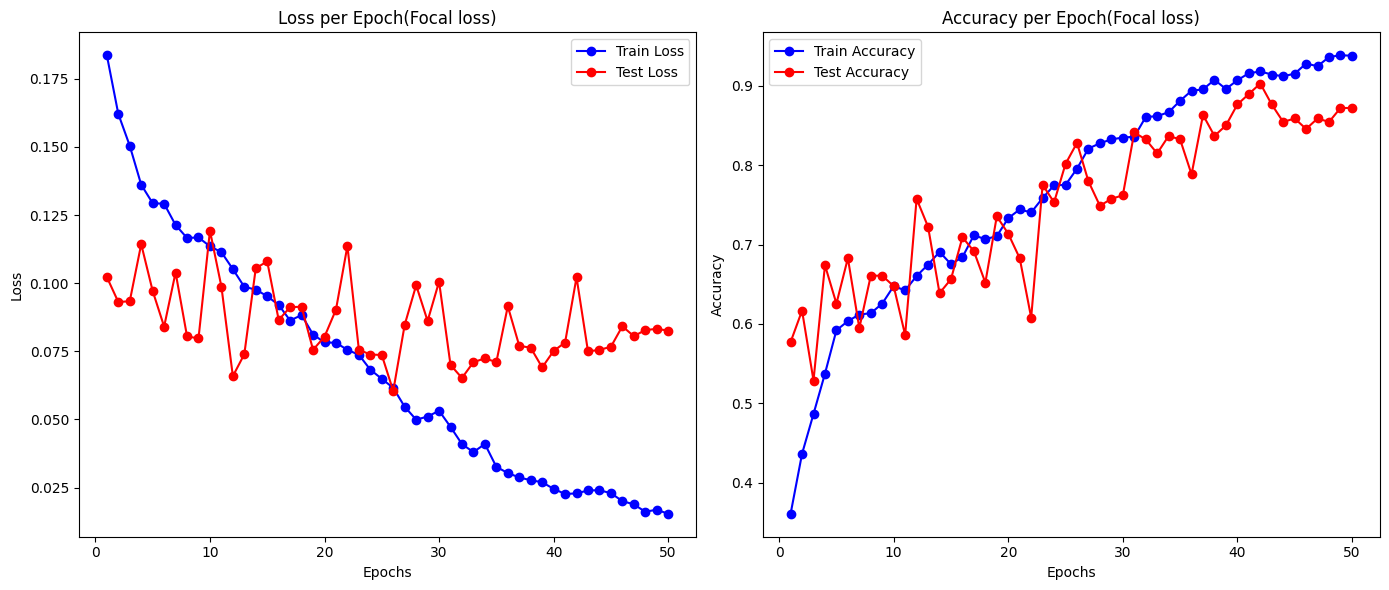

In [ ]:
def main():
    # Hyperparameters
    vocab_size = 30522
    d_model = 768
    n_layers = 12
    heads = 12
    dropout = 0.7
    max_len = 64
    batch_size = 64
    learning_rate = 1e-5
    weight_decay = 1e-3
    num_epochs = 50
    checkpoint_path = "data/bert_checkpoints/bert_checkpoint_epoch_2.pt"
    output_dir = "data/output"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    dataset = SentimentDataset("data/Sentences_AllAgree.txt", tokenizer, max_len)

    train_dataset, val_dataset, test_dataset = split_dataset(dataset, train_ratio=0.8, val_ratio=0.1)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    bert = SentimentClassifier.load_pretrained_bert(checkpoint_path, vocab_size, d_model, n_layers, heads, dropout)
    sentiment_model = SentimentClassifier(bert).to(device)

    optimizer = optim.AdamW(sentiment_model.parameters(), lr=learning_rate, weight_decay= weight_decay)
    # Use FocalLoss instead of CrossEntropyLoss
    alpha = torch.tensor([0.6, 0.15, 0.25]) # Base on the distribution on dataset: 604 negative, 2879 neutral, and 1363 positive
    criterion = FocalLoss(alpha=alpha, gamma=1.5, num_classes=3)
    # criterion = FocalLoss(alpha=alpha, gamma=4.0, num_classes=3)

    # Metrics storage for visualization
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_sentiment_classifier(sentiment_model, train_dataloader, optimizer, criterion, device)
        val_metrics = evaluate_sentiment_classifier(sentiment_model, val_dataloader, criterion, device)
        test_metrics = evaluate_sentiment_classifier(sentiment_model, test_dataloader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_metrics['loss'])
        test_accuracies.append(test_metrics['accuracy'])

        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Epoch {epoch + 1}/{num_epochs} - Val Loss: {val_metrics['loss']:.4f}, Val Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"Epoch {epoch + 1}/{num_epochs} - Test Loss: {test_metrics['loss']:.4f}, Test Accuracy: {test_metrics['accuracy']:.4f}")
        print(f"Precision: {test_metrics['precision']:.4f}, Recall: {test_metrics['recall']:.4f}, F1-Score: {test_metrics['f1']:.4f}")
        print(f"Specificity: {test_metrics['specificity']:.4f}, MCC: {test_metrics['mcc']:.4f}")

    # Final evaluation on test set
    final_test_metrics = evaluate_sentiment_classifier(sentiment_model, test_dataloader, criterion, device)
    print(f"Final Test Loss: {final_test_metrics['loss']:.4f}, Final Test Accuracy: {final_test_metrics['accuracy']:.4f}")
    print(f"Precision: {final_test_metrics['precision']:.4f}, Recall: {final_test_metrics['recall']:.4f}, F1-Score: {final_test_metrics['f1']:.4f}")
    print(f"Specificity: {final_test_metrics['specificity']:.4f}, MCC: {final_test_metrics['mcc']:.4f}")

    # Visualization
    plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, output_dir)

def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    epochs = range(1, len(train_losses) + 1)

    # Loss plot
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color="blue", marker="o")
    plt.plot(epochs, test_losses, label="Test Loss", color="red", marker="o")
    plt.title("Loss per Epoch(Focal loss)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color="blue", marker="o")
    plt.plot(epochs, test_accuracies, label="Test Accuracy", color="red", marker="o")
    plt.title("Accuracy per Epoch(Focal loss)")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plot_path = os.path.join(output_dir, "train_test_comparison_CE_loss.png")
    plt.savefig(plot_path)
    # print(f"Plot saved to {'data'}")
    plt.show()
if __name__ == "__main__":
    main()